# Hacking Evolution: Beyond Genetic Algorithms 

<style>
  .intro-cell {
    width: 80%;
  }

  .image-cell {
    width: 20%;
    text-align: right;
  }

  .name-list li {
    margin-bottom: 10px; 
  }
</style>

<table>
  <tr>
    <td class="intro-cell">
    Notebook for the Artificial Intelligence Fundamentals exam (a.y. 23/24) <br>
     <br>
    @ University of Pisa - Computer Science Department - Curriculum Artificial Intelligence <br>
     <br>
    Authors: 
      <!-- Contributors -->
      <ul class="name-list">
        <li>Irene Dovichi - <span style="font-family: 'Courier New', Courier, monospace;">i.dovichi@studenti.unipi.it</span></li>
        <li>Marco Lavorini - <span style="font-family: 'Courier New', Courier, monospace;">m.lavorini2@studenti.unipi.it</span></li>
        <li>Luca Miglior - <span style="font-family: 'Courier New', Courier, monospace;">l.miglior@studenti.unipi.it</span></li>
      </ul>
    </td>
    <td class="image-cell">
      <!-- Image -->
      <img src="assets/hactually_bunnies.png" alt="Image" width="200"/>
    </td>
  </tr>
</table>

# Introduction
Write about the problem setting: solve a maze 
- Partially Observable 🔍 🤓
- Discrete 🧩
- Non-Episodic (Sequential) ⏩
- Single Agent, Non-Adversarial 
- Deterministic 🔒
- Static finite map: start and target coordinates are fixed 🏁

Talk about what we want to achieve.

...sistemare

In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
import gym
import minihack
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import random
import math
import IPython.display as display
import os
import json
import csv
import pandas as pd
import seaborn as sns

from classes import *
from tqdm import tqdm
from utils import *

from pyswip import Prolog
from typing import List, Tuple

# fix the seed for reproducibility (not fixing the seed for the whole program since we have imports!)
random.seed(42)
np.random.seed(42)

# minihack env creation with a .des file

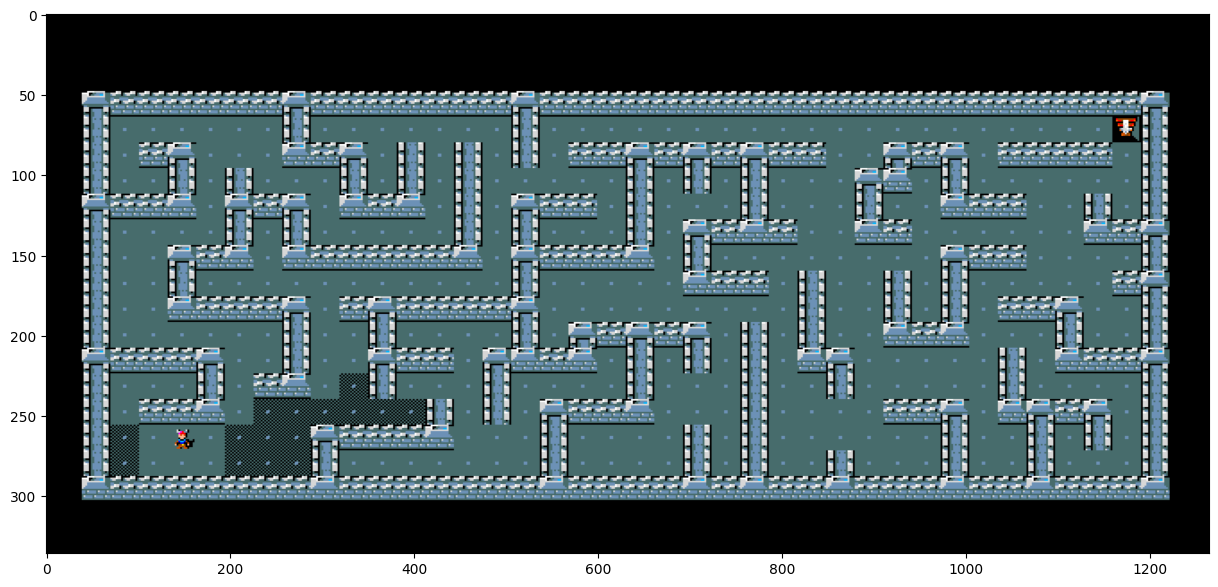

In [3]:
plt.rcParams["figure.figsize"] = [15, 7]
env = gym.make(
    "MiniHack-Navigation-Custom-v0",
    observation_keys=("chars", "pixel"),
    des_file="maps/real_maze.des",
    max_episode_steps=10000,
)
state = env.reset()
# env.render()
plt.imshow(state["pixel"], aspect="auto").set_data(state["pixel"][:, 300:950])  # type: ignore

In [4]:
# s,_,_,_ = env.step(0)

# plt.imshow(s["pixel"], aspect="auto").set_data(s["pixel"][:, 300:950])  # type: ignore

# print(get_player_location(s["chars"]))

# Map bitmap as KB

once we have created the map through the .des settings, we will create an object Map with all the basic information required by our agent

In [5]:
state = env.reset()
game_map = state["chars"]  # type: ignore
game = state["pixel"]  # type: ignore
start = get_player_location(game_map)
target = get_target_location(game_map)
game_map = Map(game_map, start, target)

During the creation of the Map() object, we will process a bitmap of the maze that will be used as our initial Knowledge.

We will print the bitmap to visualize it. Invalid cells (walls, void) will be rapresented by 1 in the bitmap and will be printed white. Valid cells will be rapresented by 0 and be black in the followinf image.

> start: (16, 23), target: (4, 56)
> map size: (21, 79)


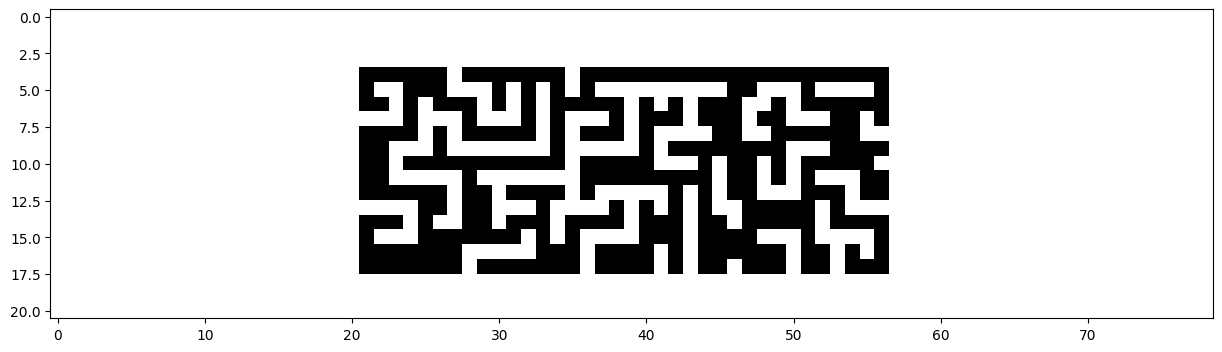

In [6]:
print(f"> start: {game_map.start}, target: {game_map.target}")
print(f"> map size: {game_map.layout.shape}")
plt.imshow(game_map.map_matrix, cmap="gray") # type: ignore
plt.show()

Here we assert the information to our KB

In [7]:
PATH = "kb/kb.pl"
KB = Prolog()
KB.consult(PATH)

KB.retractall("maze(_)")
KB.retractall("start(_,_)")
KB.asserta(f"maze({game_map.map_matrix})")
KB.asserta(f"start({game_map.start[0]}, {game_map.start[1]})")

#for i in KB.query("maze(X)"):
   # print(f'{i["X"]}\n')  # type: ignore


# 1 corrisponde alle celle bianche, che non sono percorribili


# NTH1

In Prolog, `nth1/3` is a built-in predicate that is used to access elements in a list by index. The `nth1/3` predicate has the following form:

```prolog
nth1(Index, List, Element)
```
Index: The index of the element you want to access.

List: The list from which you want to access the element.

Element: The variable that will be unified with the element at the specified index.

We will use nth1 to control the validity of a specific position of the maze though Prolog, to assert if a specific cell is valid or not. This will be also used later to check for valid actions.

In [8]:
result = list(KB.query("maze(M), nth1(17, M, Row), nth1(24, Row, Cell)"))
if result:
    cell_value = result[0]["Cell"]  # type: ignore
    print(f"Cell value: {cell_value}")
else:
    print("Query result is empty.")

solution = list(KB.query(f"is_valid(17,24)"))
if solution:
    print("Position is valid.")
else:
    print("Position is not valid.")

Cell value: 0
Position is valid.


# Findall

In Prolog, findall/3 is a built-in predicate that is used to find all solutions to a query and collect them into a list. The general form of the findall/3 predicate is:

```Prolog
findall(+Template, +Goal, -Bag)
```

Template: It represents a template for the solutions. The variables in the template are instantiated with the values of the corresponding variables in the solutions.

Goal: It is a goal (query) to be satisfied. findall/3 collects all solutions to this goal.

Bag: It is the list that will contain all the solutions found.


We then rename Actions to ValidActions using the Prolog function intersection(+Set1, +Set2, -Set3).

N.B.  the search is done for Action = 0,1,2,3 since in kb.pl 'is_valid_action' is constructed from action_to_coordinates which gives these 4 values for Action.

In [9]:
possible_actions = [0,1,2,3]
row = 16
col = 23
query_string = f"findall(Action, is_valid_action({row+1}, {col+1}, Action), Actions), intersection(Actions, {possible_actions}, ValidActions)"
results = list(KB.query(query_string))
print(results)

[{'Action': Variable(72), 'Actions': [1, 2, 3], 'ValidActions': [1, 2, 3]}]


In [10]:
# Here we print just ValidActions
valid_actions_result = results[0]['ValidActions'] # type: ignore
print(valid_actions_result)

[1, 2, 3]


In [11]:
# We check with the NON-PROLOG function if the result is correct
get_valid_actions(game_map.layout,  (row, col))

[1, 2, 3]

# Using the KB to make an Informed Genetic Algorithm

Once we have all the bits, we can create all our pillar function that will be used in the genetic algorithm and in the fitness function. In particular we will be using the following main function as building blocks.

```Python
    is_wall_kb()
    path_from_actions_kb()
    random_nvalid_actions_kb()
```

which will compute the prolog queries states above to, respectively:
- assert if a cell is valid
- generate a path from a list of action, for each action we will check its validity
- generate a list of valid action from the starting cell



In [12]:
random.seed(42)

actions = random_nactions(10)
print(actions)

path = path_from_actions(game_map= game_map.layout, start = game_map.start, actions = actions)
print(path)

path_kb = path_from_actions_kb(game_map= game_map.layout, start = game_map.start, actions = actions, KB = KB)
print(path_kb)

[2, 0, 1, 0, 2, 2, 3, 0, 1, 0]
[(17, 23), (16, 23), (16, 24), (16, 24), (17, 24), (17, 24), (17, 23), (16, 23), (16, 24), (16, 24)]
[(17, 23), (16, 23), (16, 24), (16, 24), (17, 24), (17, 24), (17, 23), (16, 23), (16, 24), (16, 24)]


In [13]:
path1 = random_nsteps(game_map= game_map.layout, start = game_map.start, target=game_map.target, steps = 10)
path1

[(16, 24),
 (16, 23),
 (16, 24),
 (16, 25),
 (15, 25),
 (16, 25),
 (16, 24),
 (16, 25),
 (17, 25),
 (16, 25)]

In [14]:
actions1 = actions_from_path(start = game_map.start, path = path1)
actions1

[1, 3, 1, 1, 0, 2, 3, 1, 2, 0]

In [15]:
path2 = path_from_actions(game_map= game_map.layout, start = game_map.start, actions = actions1)
path2

[(16, 24),
 (16, 23),
 (16, 24),
 (16, 25),
 (15, 25),
 (16, 25),
 (16, 24),
 (16, 25),
 (17, 25),
 (16, 25)]

In [16]:
# generating a full valid random path to feed at the first generation
starting_path = random_nsteps(game_map= game_map.layout, start = game_map.start, target=game_map.target, steps = 300)
starting_actions = actions_from_path(start = game_map.start, path = starting_path)
print(len(starting_actions))
print(starting_actions)

300
[1, 1, 1, 0, 3, 0, 0, 2, 0, 1, 0, 2, 0, 2, 3, 2, 0, 1, 0, 3, 3, 3, 3, 0, 0, 2, 0, 2, 2, 0, 2, 0, 0, 3, 0, 2, 0, 0, 2, 2, 0, 1, 3, 1, 2, 2, 3, 1, 3, 1, 0, 0, 3, 0, 2, 1, 3, 1, 2, 2, 2, 1, 1, 1, 2, 2, 2, 1, 2, 0, 2, 2, 1, 0, 2, 3, 0, 0, 2, 1, 3, 2, 3, 3, 1, 0, 3, 2, 3, 3, 3, 1, 0, 3, 2, 1, 0, 3, 2, 0, 0, 2, 0, 2, 0, 2, 2, 1, 3, 0, 0, 0, 2, 0, 2, 2, 1, 3, 0, 2, 1, 3, 0, 0, 1, 1, 3, 3, 2, 2, 0, 2, 0, 0, 2, 2, 2, 0, 0, 2, 1, 1, 1, 3, 1, 1, 2, 1, 3, 0, 1, 0, 1, 3, 3, 1, 3, 0, 2, 2, 1, 1, 3, 0, 3, 0, 2, 0, 0, 1, 0, 3, 2, 2, 2, 1, 2, 2, 0, 0, 2, 1, 3, 1, 2, 3, 3, 3, 0, 2, 3, 3, 3, 1, 0, 2, 0, 3, 1, 3, 2, 1, 1, 0, 1, 2, 3, 3, 1, 3, 1, 1, 0, 2, 0, 3, 3, 3, 2, 1, 3, 0, 1, 2, 0, 3, 2, 1, 0, 2, 1, 3, 1, 1, 0, 1, 1, 0, 1, 3, 1, 2, 3, 0, 2, 2, 1, 3, 0, 0, 3, 2, 0, 0, 0, 2, 2, 0, 0, 0, 2, 0, 1, 3, 1, 2, 3, 2, 0, 0, 2, 2, 2, 2, 3, 2, 0, 1, 2, 1, 0, 1, 2, 0, 3, 0, 3, 1, 3, 1, 3, 2, 0, 0, 2, 2, 3, 1, 1, 0]


In [17]:
actions = random_nvalid_actions_kb(start = game_map.start, target=game_map.target, steps = 300, KB = KB)

In [18]:

path = path_from_actions_kb(game_map= game_map.layout, start = game_map.start, actions = actions, KB = KB)
w = wrong_actions(path=path)
print(w)

0


## Fitness Function

Say how it is defined in words + reference to file .py 

Definition of loops, dead ends and wrong actions

Run the following cells for visualizing them.


# Informed Genetic Algorithm

### Informed mutations

In order to improve the performance of the standard genetic algorithm, we decided to implement a new mutation operator. In particular, this operator will take KB-generated bitmaps of the errors made by the parents, in order to prevent the offspring from making the same mistakes. Bitmaps are vectors of 0s and 1s. Given a generic error bitmap $k$, the $i$ th $k_i$ component is set to 1 if the best individual in the previous generation made an error in the $i$ th action of its path. 

We consider in particular three kind of errors:
- Loops: the agent goes back to a cell that it has already visited
- Dead ends: the agent goes to a cell that has no valid actions
- Wrong actions: the agent goes against a wall.

In order to perform the informed mutation, we want the positions where the parents made an error to be more likely to be mutated. We decided to implement this by computing a probability distribution over the errors. 
Thus, we sum up the error bitmaps, generating a new bitmap $$b = wrongactions + loops + deadends$$ Then, we apply the softmax function to each component of $b$, as follows:
$$ p_i = \frac{e^{b_i}}{\sum_{j=1}^{n} e^{b_j}}$$
where $p_i$ is the probability of mutating the $i$ th component of the new individuals.

Code for the `softmax_mutate()` method can be found in the `classes.py` file.

### Python implementation

The following code describes the genetic algorithm used to solve the maze. We decided to implement a standard variation of a genetic algorithm. Steps performed are the following:

1. Generate a population of individuals: each individual is a list of actions (0,1,2,3) that will be used to generate a path from the starting cell to the target cell. The population is generated by randomly sampling the valid actions from the starting cell. The number of individuals in the population is specified by the user.

2. Evaluate the fitness of each individual: the fitness of each individual is computed by the fitness function described in the next section.

3. Select the best individuals: at each generation, we select the two individuals with the highest fitness score. These individuals will be used to generate the next generation.
   
4. Generate the next generation: the next generation is generated by applying the crossover and mutation operators to the two selected individuals. We firstly select a random crossover point among the actions of the two individuals, in order to generate a new sequence of actions. Crossover is performed by the function `crossover()`, for each of one of the new individuals: e.g. if our offspring contains 24 new individuals, we will perform crossover 24 times. 
   
5. Then, we apply the mutation operator to each of the new individuals. Mutation is performed by the function `softmax_mutate()` method, according to the probability distribution described in the previous section. We let the user specify the actual number of mutatins to be performed, in order to control the exploration-exploitation tradeoff.

6. Repeat from step 2 until the target is reached or the maximum number of generations is reached!
   

In [19]:
### USING THE MANHATTAN DISTANCE AS FITNESS FUNCTION ###

# fix rng seed for reproducibility
random.seed(42)
np.random.seed(42)

# create first generation
MAX_GENERATIONS = 1000
MAX_INDIVIDUALS = 24

best_individuals = []

print("> Creating initial population...")
"""individuals = [
    Individual(starting_actions, 1, game_map) for _ in range(MAX_INDIVIDUALS)
]
"""
individuals = [
    Individual(random_nactions(300), 1, game_map) for _ in range(MAX_INDIVIDUALS)
]
individuals.sort(key=lambda x: x.fitness, reverse=True)
print("> Evolving...")

with tqdm(total=MAX_GENERATIONS, colour='#9244c9', ncols=150) as pbar:
    for generation in range(MAX_GENERATIONS):
        best_fitness = individuals[0].fitness
        best_individuals.append(individuals[0])
        if generation % 25 == -1:
            print(
                format_loop.format(
                    generation,
                    best_fitness,
                    individuals[0].wrong_actions,
                    individuals[0].loops,
                    individuals[0].dead_ends,
                    individuals[0].distance,
                )
            )

        # take 2 best individuals -> maybe can be replaced with probability distribution based on fitness
        # also roulette wheel selection.
        p1, p2 = individuals[0], individuals[1]
        errors = p1.error_vector + p2.error_vector
        offspring = [
            softmax_mutate(
                crossover(p1.actions, p2.actions), ##
                errors, 
                generation=generation, 
                mutation_rate=0.8,
                max_generations=MAX_GENERATIONS,
                decay = not(p1.won),
            )
            for _ in range(MAX_INDIVIDUALS)
        ]

        individuals[2:] = [
            Individual(offspring[i], generation + 1, game_map)
            for i in range(MAX_INDIVIDUALS - 2)
        ]
        individuals.sort(key=lambda x: x.fitness, reverse=True)

        if individuals[0].fitness == 0:
            print(
                f"> best individual in generation {generation}: {individuals[0].fitness}, wrong actions: {individuals[0].wrong_actions}"
            )
            break

        pbar.set_postfix(
            best_fitness=best_fitness, 
            distance=individuals[0].distance, 
            dead_ends=individuals[0].dead_ends, 
            loops=individuals[0].loops, 
            wrong_actions=individuals[0].wrong_actions,
            refresh=False
        )
        
        pbar.update(1)

best_fitness = individuals[0].fitness
best_individuals.append(individuals[0])

> Creating initial population...
> Evolving...


  5%|██▏                                     | 54/1000 [00:07<02:03,  7.64it/s, best_fitness=-4, dead_ends=0, distance=4, loops=96, wrong_actions=123]

> best individual in generation 54: 0, wrong actions: 115


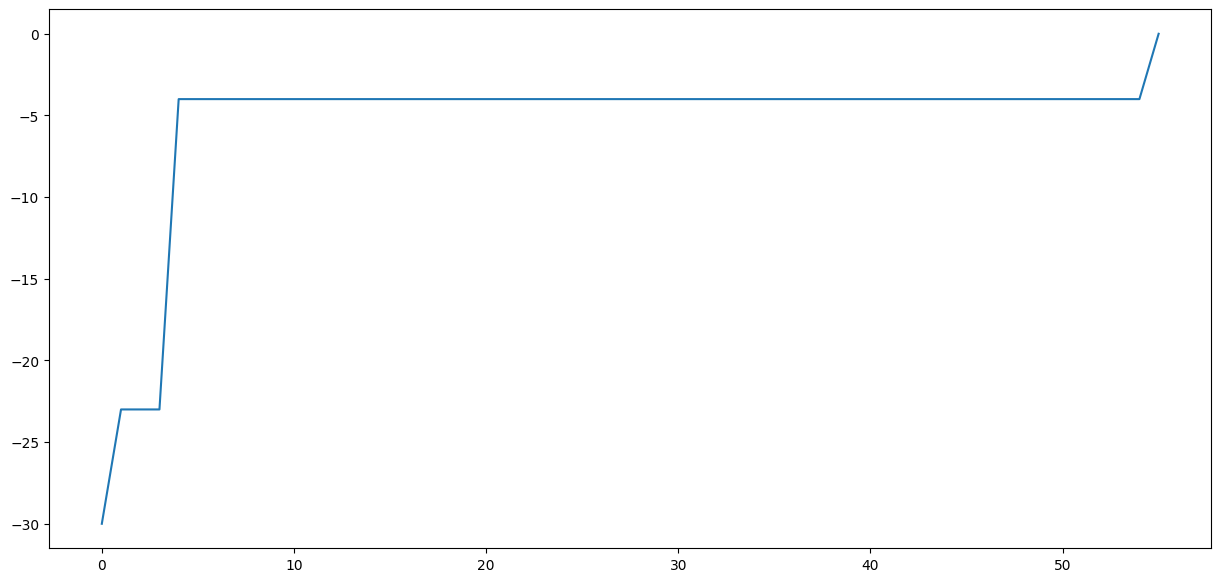

In [20]:
# Plot for each generation the best fitness
best_fitness = [best_individuals[i].fitness for i in range(len(best_individuals))]
plt.plot(best_fitness)

In [ ]:
env.reset()
plt.rcParams["figure.figsize"] = [18, 7]

image = plt.imshow(game[:, 350:1500])
# for generation, path in enumerate(best_paths):
# plt.title(f"Generation {generation}, fitness: {best_scores[generation]:.2f}, last move: {path[-1]}")
# start = best_paths[0]
# path = best_paths[-1]
actions = []
actions = individuals[0].actions
wrong = 0

for i, action in enumerate(actions):
    try:
        s, _, _, _ = env.step(action)
        display.display(plt.gcf())
        display.clear_output(wait=True)
        plt.title(
            format_title.format(
                individuals[0].generation,
                individuals[0].fitness,
                individuals[0].path[i],
                action,
                wrong,
                individuals[0].loops,
                individuals[0].dead_ends,
                i + 1,
                len(actions),
            )
        )
        image.set_data(s["pixel"][:, 300:1200])
        # time.sleep(0.1)
        if individuals[0].path[i] == game_map.target:
            print("YOU WON!")
            break
        if individuals[0].path[i] == individuals[0].path[i - 1]:
            wrong += 1
    except RuntimeError:
        print("YOU WON!")

In [21]:
### USING THE INFORMED MANHATTAN DISTANCE AS FITNESS FUNCTION ### 

# reset rng
random.seed(42)
np.random.seed(42)

state = env.reset()
game_map = state["chars"]  # type: ignore
game = state["pixel"]  # type: ignore
start = get_player_location(game_map)
target = get_target_location(game_map)
game_map = Map(game_map, start, target)

In [22]:
# create first generation
MAX_GENERATIONS = 1000
MAX_INDIVIDUALS = 24

best_individuals = []

print("> Creating initial population...")
"""individuals = [
    Individual(starting_actions, 1, game_map) for _ in range(MAX_INDIVIDUALS)
]
"""
individuals = [
    Individual(random_nactions(300), 1, game_map, fitness=1) for _ in range(MAX_INDIVIDUALS)
]
individuals.sort(key=lambda x: x.fitness, reverse=True)
print("> Evolving...")

with tqdm(total=MAX_GENERATIONS, colour='#9244c9', ncols=150) as pbar:
    for generation in range(MAX_GENERATIONS):
        best_fitness = individuals[0].fitness
        best_individuals.append(individuals[0])
        if generation % 25 == -1:
            print(
                format_loop.format(
                    generation,
                    best_fitness,
                    individuals[0].wrong_actions,
                    individuals[0].loops,
                    individuals[0].dead_ends,
                    individuals[0].distance,
                )
            )

        # take 2 best individuals -> maybe can be replaced with probability distribution based on fitness
        # also roulette wheel selection.
        p1, p2 = individuals[0], individuals[1]
        errors = p1.error_vector + p2.error_vector
        offspring = [
            softmax_mutate(
                crossover(p1.actions, p2.actions), ##
                errors, 
                generation=generation, 
                mutation_rate=0.8,
                max_generations=MAX_GENERATIONS,
                decay = not(p1.won),
            )
            for _ in range(MAX_INDIVIDUALS)
        ]

        individuals[2:] = [
            Individual(offspring[i], generation + 1, game_map, fitness=1)
            for i in range(MAX_INDIVIDUALS - 2)
        ]
        individuals.sort(key=lambda x: x.fitness, reverse=True)

        if individuals[0].fitness == 0:
            print(
                f"> best individual in generation {generation}: {individuals[0].fitness}, wrong actions: {individuals[0].wrong_actions}"
            )
            break

        pbar.set_postfix(
            best_fitness=best_fitness, 
            distance=individuals[0].distance, 
            dead_ends=individuals[0].dead_ends, 
            loops=individuals[0].loops, 
            wrong_actions=individuals[0].wrong_actions,
            refresh=False
        )
        
        pbar.update(1)

best_fitness = individuals[0].fitness
best_individuals.append(individuals[0])

> Creating initial population...
> Evolving...


100%|███████████████████████████████████████| 1000/1000 [02:06<00:00,  7.92it/s, best_fitness=-2, dead_ends=0, distance=0, loops=54, wrong_actions=54]


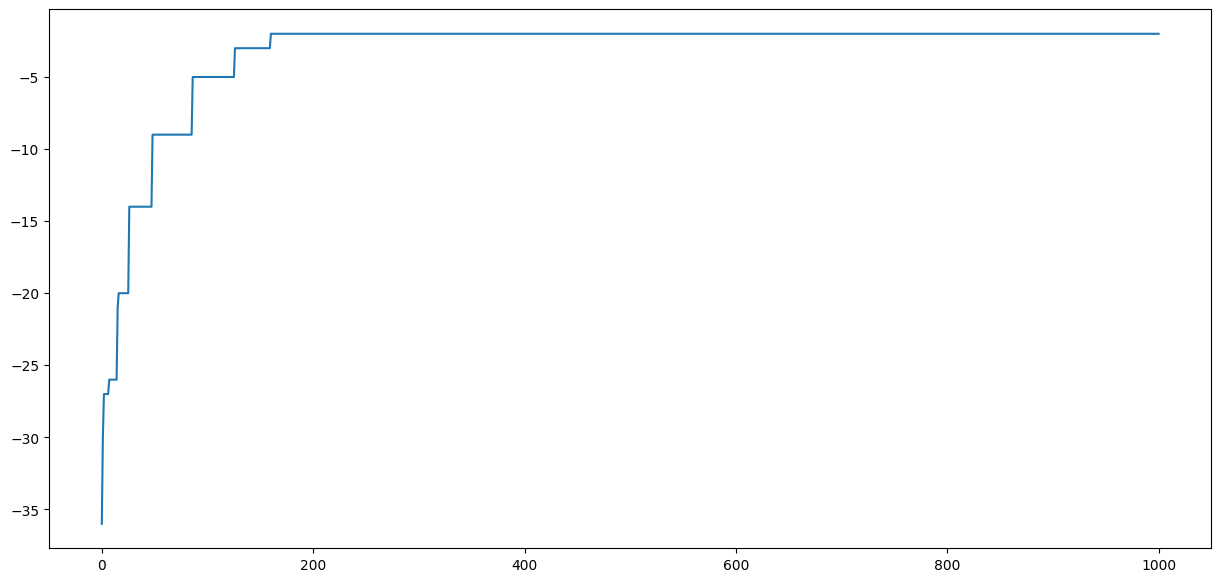

In [68]:
# Plot for each generation the best fitness
best_fitness = [best_individuals[i].fitness for i in range(len(best_individuals))]
plt.plot(best_fitness)

YOU WON!


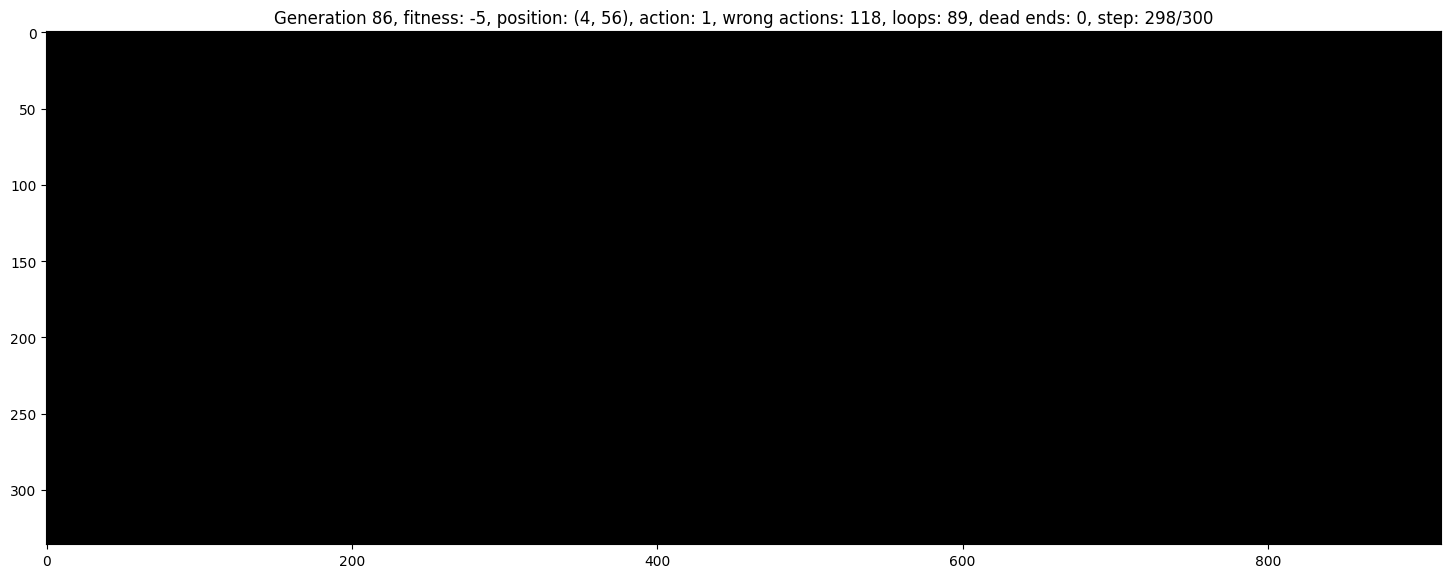

In [39]:
env.reset()
plt.rcParams["figure.figsize"] = [18, 7]

image = plt.imshow(game[:, 350:1500])
# for generation, path in enumerate(best_paths):
# plt.title(f"Generation {generation}, fitness: {best_scores[generation]:.2f}, last move: {path[-1]}")
# start = best_paths[0]
# path = best_paths[-1]
actions = []
actions = individuals[0].actions
wrong = 0

for i, action in enumerate(actions):
    try:
        s, _, _, _ = env.step(action)
        display.display(plt.gcf())
        display.clear_output(wait=True)
        plt.title(
            format_title.format(
                individuals[0].generation,
                individuals[0].fitness,
                individuals[0].path[i],
                action,
                wrong,
                individuals[0].loops,
                individuals[0].dead_ends,
                i + 1,
                len(actions),
            )
        )
        image.set_data(s["pixel"][:, 300:1200])
        # time.sleep(0.1)
        if individuals[0].path[i] == game_map.target:
            print("YOU WON!")
            break
        if individuals[0].path[i] == individuals[0].path[i - 1]:
            wrong += 1
    except RuntimeError:
        print("YOU WON!")

We do the same experiment using the dynamic fitness function.

In [73]:
### USING THE DYNAMIC FITNESS FUNCTION ###

# reset rng
random.seed(42)
np.random.seed(42)

state = env.reset()
game_map = state["chars"]  # type: ignore
game = state["pixel"]  # type: ignore
start = get_player_location(game_map)
target = get_target_location(game_map)
game_map = Map(game_map, start, target)

In [74]:
# create first generation
MAX_GENERATIONS = 1000
MAX_INDIVIDUALS = 24

best_individuals = []

print("> Creating initial population...")
"""individuals = [
    Individual(starting_actions, 1, game_map) for _ in range(MAX_INDIVIDUALS)
]
"""
individuals = [
    Individual(random_nactions(300), 1, game_map, fitness=2) for _ in range(MAX_INDIVIDUALS)
]
individuals.sort(key=lambda x: x.fitness, reverse=True)
print("> Evolving...")

with tqdm(total=MAX_GENERATIONS, colour='#9244c9', ncols=150) as pbar:
    for generation in range(MAX_GENERATIONS):
        best_fitness = individuals[0].fitness
        best_individuals.append(individuals[0])
        if generation % 25 == -1:
            print(
                format_loop.format(
                    generation,
                    best_fitness,
                    individuals[0].wrong_actions,
                    individuals[0].loops,
                    individuals[0].dead_ends,
                    individuals[0].distance,
                )
            )

        # take 2 best individuals -> maybe can be replaced with probability distribution based on fitness
        # also roulette wheel selection.
        p1, p2 = individuals[0], individuals[1]
        errors = p1.error_vector + p2.error_vector
        offspring = [
            softmax_mutate(
                crossover(p1.actions, p2.actions), ##
                errors, 
                generation=generation, 
                mutation_rate=0.8,
                max_generations=MAX_GENERATIONS,
                decay = not(p1.won),
            )
            for _ in range(MAX_INDIVIDUALS)
        ]

        individuals[2:] = [
            Individual(offspring[i], generation + 1, game_map, fitness=2)
            for i in range(MAX_INDIVIDUALS - 2)
        ]
        individuals.sort(key=lambda x: x.fitness, reverse=True)

        if individuals[0].fitness == 0:
            print(
                f"> best individual in generation {generation}: {individuals[0].fitness}, wrong actions: {individuals[0].wrong_actions}"
            )
            break

        pbar.set_postfix(
            best_fitness=best_fitness, 
            distance=individuals[0].distance, 
            dead_ends=individuals[0].dead_ends, 
            loops=individuals[0].loops, 
            wrong_actions=individuals[0].wrong_actions,
            refresh=False
        )
        
        pbar.update(1)

best_fitness = individuals[0].fitness
best_individuals.append(individuals[0])

> Creating initial population...
> Evolving...


100%|█████████████████████████████████████| 1000/1000 [02:05<00:00,  7.98it/s, best_fitness=-103, dead_ends=0, distance=0, loops=44, wrong_actions=59]


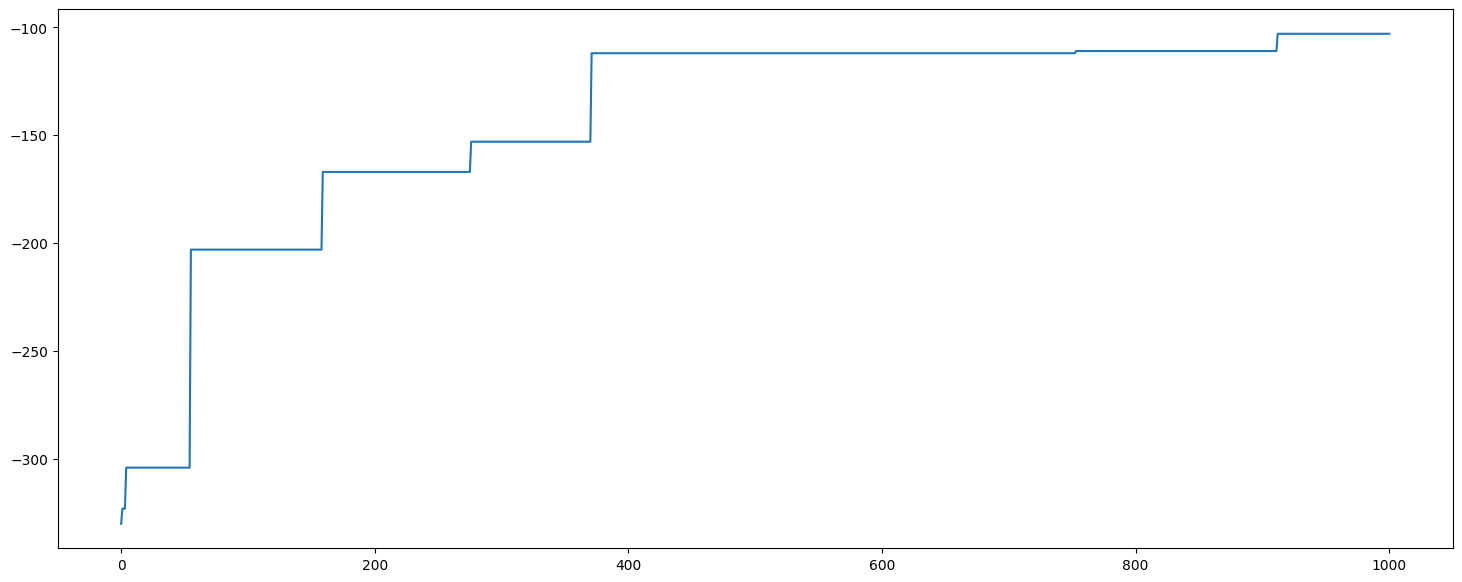

In [75]:
# Plot for each generation the best fitness
best_fitness = [best_individuals[i].fitness for i in range(len(best_individuals))]
plt.plot(best_fitness)

YOU WON!


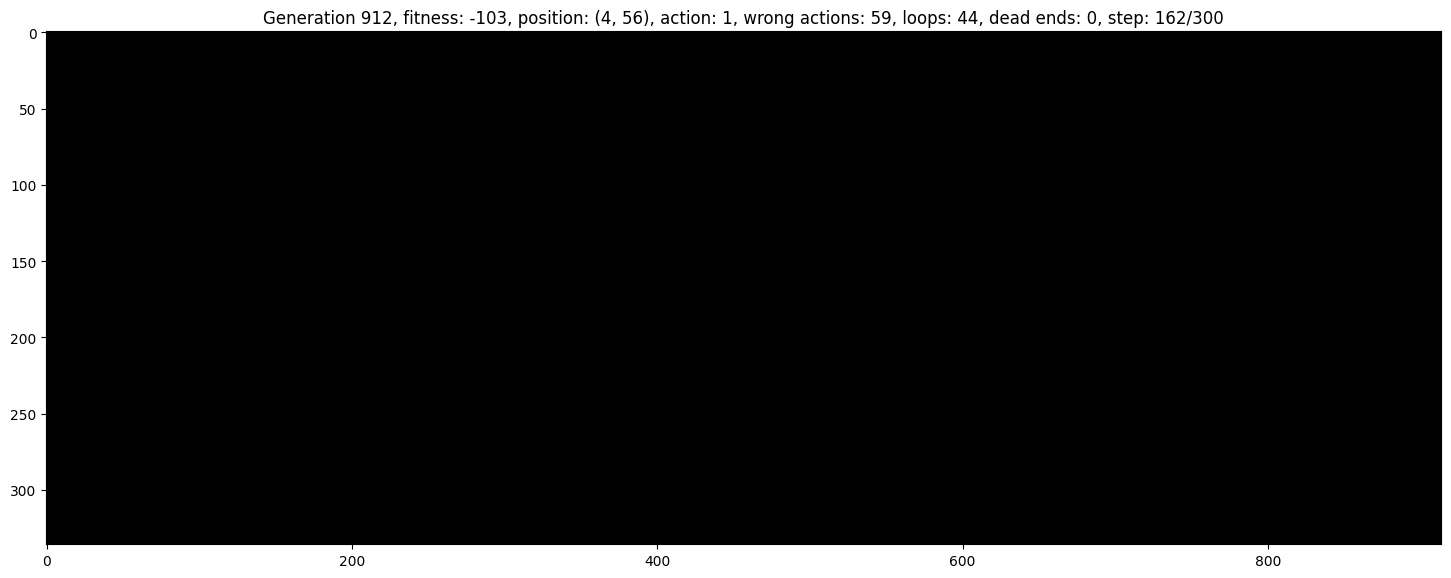

In [72]:
env.reset()
plt.rcParams["figure.figsize"] = [18, 7]

image = plt.imshow(game[:, 350:1500])
# for generation, path in enumerate(best_paths):
# plt.title(f"Generation {generation}, fitness: {best_scores[generation]:.2f}, last move: {path[-1]}")
# start = best_paths[0]
# path = best_paths[-1]
actions = []
actions = individuals[0].actions
wrong = 0

for i, action in enumerate(actions):
    try:
        s, _, _, _ = env.step(action)
        display.display(plt.gcf())
        display.clear_output(wait=True)
        plt.title(
            format_title.format(
                individuals[0].generation,
                individuals[0].fitness,
                individuals[0].path[i],
                action,
                wrong,
                individuals[0].loops,
                individuals[0].dead_ends,
                i + 1,
                len(actions),
            )
        )
        image.set_data(s["pixel"][:, 300:1200])
        # time.sleep(0.1)
        if individuals[0].path[i] == game_map.target:
            print("YOU WON!")
            break
        if individuals[0].path[i] == individuals[0].path[i - 1]:
            wrong += 1
    except RuntimeError:
        print("YOU WON!")

We can notice that the quality of the path has increased.

# Assessment
In the file `run_experiments.py` we have a script that permits to run some experimets.

Results in result folder

for the manhattan distance, for the informed manhattand fitness function and for the dynamic distance:

- for 8 individuals per generation
- 16
- 32

For each case we will have `stats.csv` that contains... and `fitness.json` which contains...

In the following we plot the results.

We can observe that the informed manhattan fitness function doesn't improve that much with respect to the simple manhattan distance, while with the dynamic fitness function we assist to an improvement of the quality of the paths in terms of loops and wrong actions.

#TODO: verificare queste affermazioni e fare qualche commento sul fatto che manhattand distance arriva a 0, informed manhattan arriva a -5 tipo e l'altra a -100 tipo

### Simple Manhattan Distance

In [5]:
stats_8 = pd.read_csv('../project/results_0/run_8_map_real_maze/stats.csv')
stats_16 = pd.read_csv('../project/results_0/run_16_map_real_maze/stats.csv')
stats_32 = pd.read_csv('../project/results_0/run_32_map_real_maze/stats.csv')

with open('../project/results_0/run_8_map_real_maze/fitnesses.json') as f:
    fitnesses_8 = json.load(f)


with open('../project/results_0/run_16_map_real_maze/fitnesses.json') as f:
    fitnesses_16 = json.load(f)


with open('../project/results_0/run_32_map_real_maze/fitnesses.json') as f:
    fitnesses_32 = json.load(f)


# convert fitnesses to np arrays
fitnesses_8 = np.array(fitnesses_8)
fitnesses_16 = np.array(fitnesses_16)
fitnesses_32 = np.array(fitnesses_32)
    
fitnesses_16.shape

(100, 1000)

In [6]:
stats_8.head()

,best_fitness,generation,wrong_actions,loops,dead_ends,distance,first_winner
0,0,161,84,57,0,0,161
1,0,74,127,97,0,0,74
2,0,331,90,89,0,0,331
3,0,44,97,78,0,0,44
4,0,375,113,77,0,0,375


In [7]:
# count nans for stats_8
nans_8 = stats_8['first_winner'].isna().sum()
nans_16 = stats_16['first_winner'].isna().sum()
nans_32 = stats_32['first_winner'].isna().sum()

# compute win rate as 1 - nans / total
win_rate_8 = 1 - nans_8 / len(stats_8)
win_rate_16 = 1 - nans_16 / len(stats_16)
win_rate_32 = 1 - nans_32 / len(stats_32)

print('win rate 8: ', win_rate_8)
print('win rate 16: ', win_rate_16)
print('win rate 32: ', win_rate_32)

win rate 8:  1.0
win rate 16:  1.0
win rate 32:  1.0


<Axes: xlabel='first_winner', ylabel='Count'>

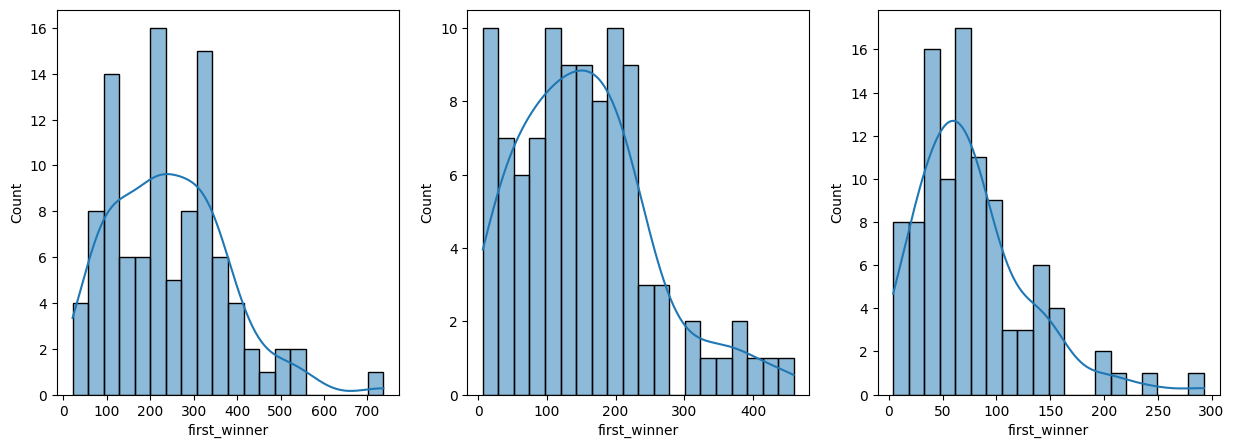

In [8]:
fix, axs = plt.subplots(1, 3, figsize=(15, 5))
sns.histplot(data=stats_8['first_winner'], ax=axs[0], kde=True, bins=20)
sns.histplot(data=stats_16['first_winner'], ax=axs[1], kde=True, bins=20)
sns.histplot(data=stats_32['first_winner'], ax=axs[2], kde=True, bins=20)

<Axes: xlabel='best_fitness', ylabel='Count'>

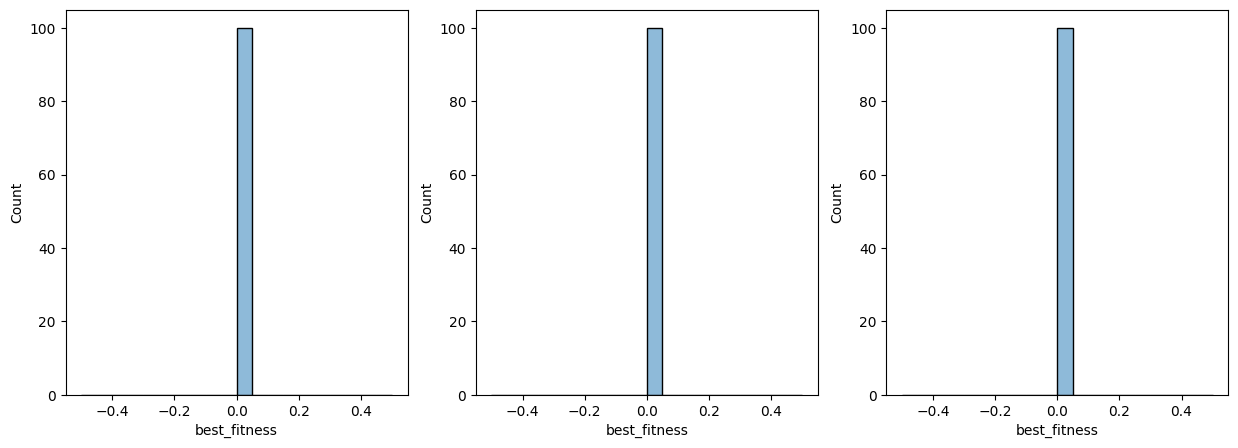

In [9]:
# do the same for best_fitness
fix, axs = plt.subplots(1, 3, figsize=(15, 5))
sns.histplot(data=stats_8['best_fitness'], ax=axs[0], kde=True, bins=20)
sns.histplot(data=stats_16['best_fitness'], ax=axs[1], kde=True, bins=20)
sns.histplot(data=stats_32['best_fitness'], ax=axs[2], kde=True, bins=20)

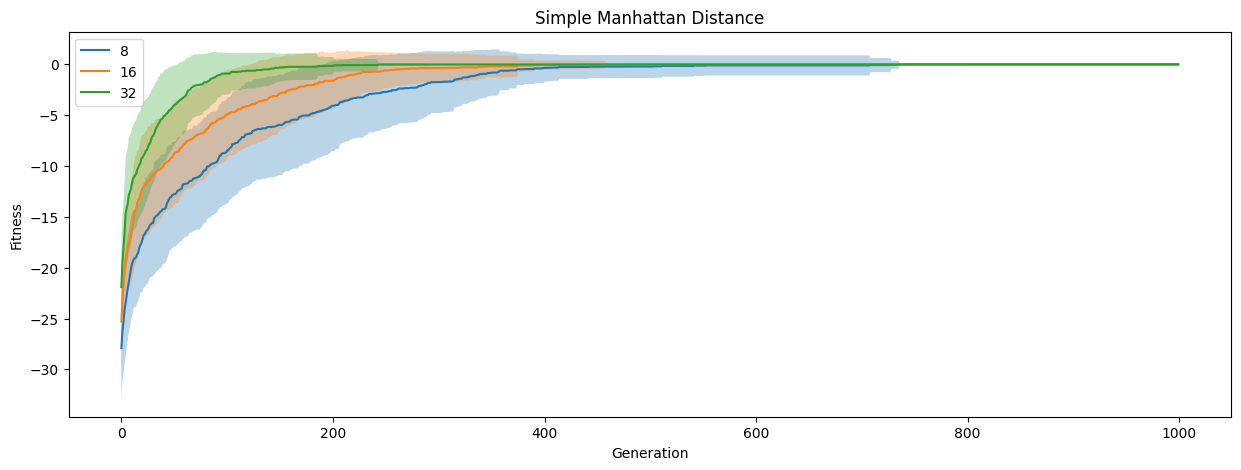

In [12]:
# from fitnesses array make a lineplot which is the mean of the 100 experiments and the std is the area around the mean
# compute mean and std
mean_8 = np.mean(fitnesses_8, axis=0)
mean_16 = np.mean(fitnesses_16, axis=0)
mean_32 = np.mean(fitnesses_32, axis=0)

std_8 = np.std(fitnesses_8, axis=0)
std_16 = np.std(fitnesses_16, axis=0)
std_32 = np.std(fitnesses_32, axis=0)

plt.figure(figsize=(15, 5))
plt.plot(mean_8, label='8')
plt.fill_between(range(len(mean_8)), mean_8-std_8, mean_8+std_8, alpha=0.3)
plt.plot(mean_16, label='16')
plt.fill_between(range(len(mean_16)), mean_16-std_16, mean_16+std_16, alpha=0.3)
plt.plot(mean_32, label='32')
plt.fill_between(range(len(mean_32)), mean_32-std_32, mean_32+std_32, alpha=0.3)
plt.xlabel('Generation')
plt.ylabel('Fitness')
plt.title('Simple Manhattan Distance')
plt.legend()
plt.show()

### Informed Manhattan Distance

In [13]:
stats_8 = pd.read_csv('../project/results_1/run_8_map_real_maze/stats.csv')
stats_16 = pd.read_csv('../project/results_1/run_16_map_real_maze/stats.csv')
stats_32 = pd.read_csv('../project/results_1/run_32_map_real_maze/stats.csv')

with open('../project/results_1/run_8_map_real_maze/fitnesses.json') as f:
    fitnesses_8 = json.load(f)


with open('../project/results_1/run_16_map_real_maze/fitnesses.json') as f:
    fitnesses_16 = json.load(f)


with open('../project/results_1/run_32_map_real_maze/fitnesses.json') as f:
    fitnesses_32 = json.load(f)


# convert fitnesses to np arrays
fitnesses_8 = np.array(fitnesses_8)
fitnesses_16 = np.array(fitnesses_16)
fitnesses_32 = np.array(fitnesses_32)
    
fitnesses_16.shape

(100, 1000)

In [14]:
# count nans for stats_8
nans_8 = stats_8['first_winner'].isna().sum()
nans_16 = stats_16['first_winner'].isna().sum()
nans_32 = stats_32['first_winner'].isna().sum()

# compute win rate as 1 - nans / total
win_rate_8 = 1 - nans_8 / len(stats_8)
win_rate_16 = 1 - nans_16 / len(stats_16)
win_rate_32 = 1 - nans_32 / len(stats_32)

print('win rate 8: ', win_rate_8)
print('win rate 16: ', win_rate_16)
print('win rate 32: ', win_rate_32)

win rate 8:  1.0
win rate 16:  1.0
win rate 32:  1.0


<Axes: xlabel='first_winner', ylabel='Count'>

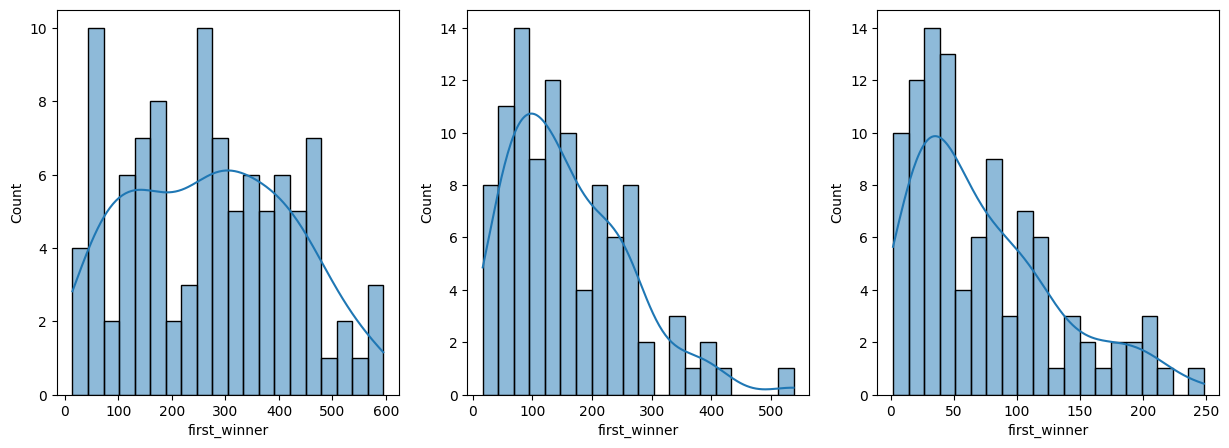

In [15]:
fix, axs = plt.subplots(1, 3, figsize=(15, 5))
sns.histplot(data=stats_8['first_winner'], ax=axs[0], kde=True, bins=20)
sns.histplot(data=stats_16['first_winner'], ax=axs[1], kde=True, bins=20)
sns.histplot(data=stats_32['first_winner'], ax=axs[2], kde=True, bins=20)

<Axes: xlabel='best_fitness', ylabel='Count'>

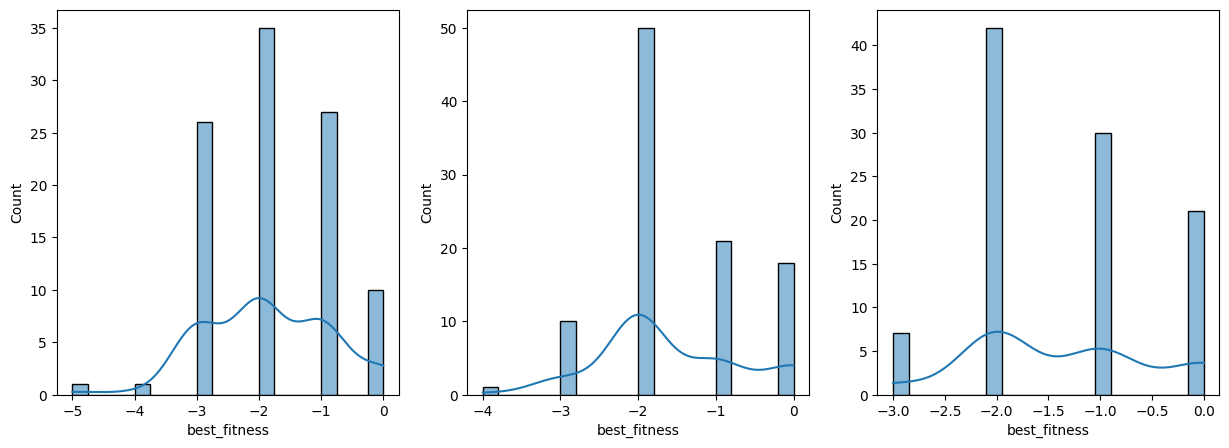

In [16]:
# do the same for best_fitness
fix, axs = plt.subplots(1, 3, figsize=(15, 5))
sns.histplot(data=stats_8['best_fitness'], ax=axs[0], kde=True, bins=20)
sns.histplot(data=stats_16['best_fitness'], ax=axs[1], kde=True, bins=20)
sns.histplot(data=stats_32['best_fitness'], ax=axs[2], kde=True, bins=20)

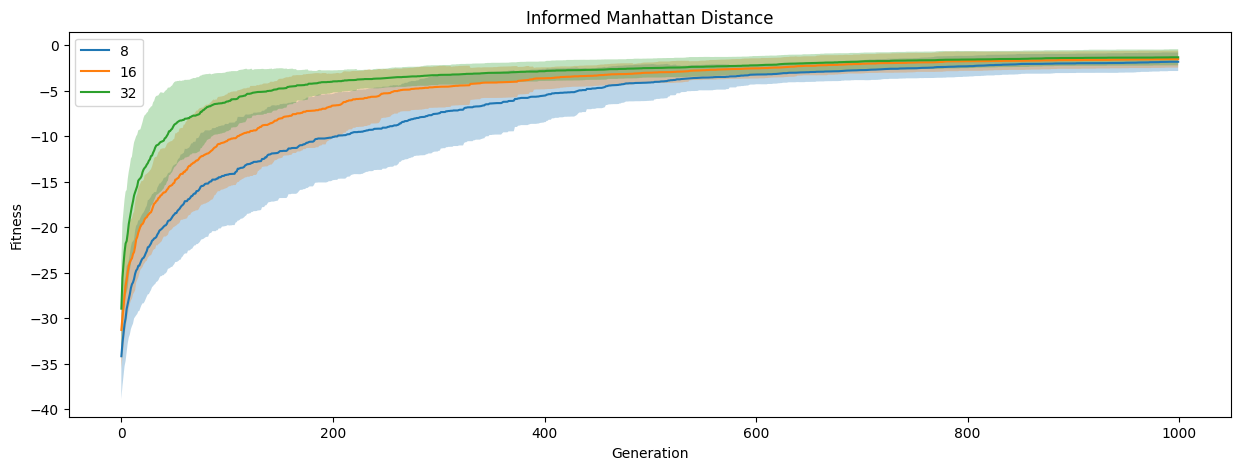

In [17]:
# from fitnesses array make a lineplot which is the mean of the 100 experiments and the std is the area around the mean
# compute mean and std
mean_8 = np.mean(fitnesses_8, axis=0)
mean_16 = np.mean(fitnesses_16, axis=0)
mean_32 = np.mean(fitnesses_32, axis=0)

std_8 = np.std(fitnesses_8, axis=0)
std_16 = np.std(fitnesses_16, axis=0)
std_32 = np.std(fitnesses_32, axis=0)

plt.figure(figsize=(15, 5))
plt.plot(mean_8, label='8')
plt.fill_between(range(len(mean_8)), mean_8-std_8, mean_8+std_8, alpha=0.3)
plt.plot(mean_16, label='16')
plt.fill_between(range(len(mean_16)), mean_16-std_16, mean_16+std_16, alpha=0.3)
plt.plot(mean_32, label='32')
plt.fill_between(range(len(mean_32)), mean_32-std_32, mean_32+std_32, alpha=0.3)
plt.xlabel('Generation')
plt.ylabel('Fitness')
plt.title('Informed Manhattan Distance')
plt.legend()
plt.show()

### Dynamic Fitness Function

In [18]:
stats_8 = pd.read_csv('../project/results_2/run_8_map_real_maze/stats.csv')
stats_16 = pd.read_csv('../project/results_2/run_16_map_real_maze/stats.csv')
stats_32 = pd.read_csv('../project/results_2/run_32_map_real_maze/stats.csv')

with open('../project/results_2/run_8_map_real_maze/fitnesses.json') as f:
    fitnesses_8 = json.load(f)


with open('../project/results_2/run_16_map_real_maze/fitnesses.json') as f:
    fitnesses_16 = json.load(f)


with open('../project/results_2/run_32_map_real_maze/fitnesses.json') as f:
    fitnesses_32 = json.load(f)


# convert fitnesses to np arrays
fitnesses_8 = np.array(fitnesses_8)
fitnesses_16 = np.array(fitnesses_16)
fitnesses_32 = np.array(fitnesses_32)
    
fitnesses_16.shape

(100, 1000)

In [19]:
# count nans for stats_8
nans_8 = stats_8['first_winner'].isna().sum()
nans_16 = stats_16['first_winner'].isna().sum()
nans_32 = stats_32['first_winner'].isna().sum()

# compute win rate as 1 - nans / total
win_rate_8 = 1 - nans_8 / len(stats_8)
win_rate_16 = 1 - nans_16 / len(stats_16)
win_rate_32 = 1 - nans_32 / len(stats_32)

print('win rate 8: ', win_rate_8)
print('win rate 16: ', win_rate_16)
print('win rate 32: ', win_rate_32)

win rate 8:  1.0
win rate 16:  1.0
win rate 32:  1.0


<Axes: xlabel='first_winner', ylabel='Count'>

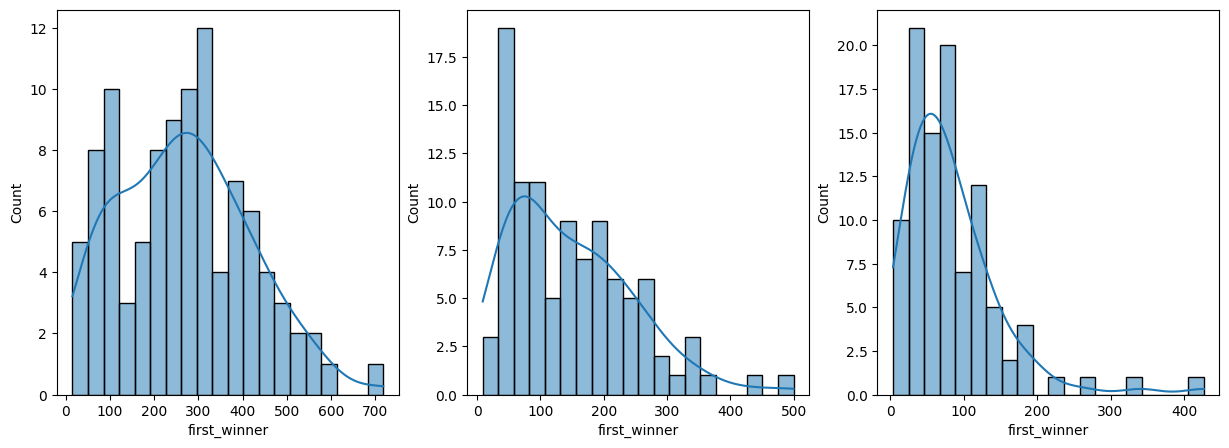

In [20]:
fix, axs = plt.subplots(1, 3, figsize=(15, 5))
sns.histplot(data=stats_8['first_winner'], ax=axs[0], kde=True, bins=20)
sns.histplot(data=stats_16['first_winner'], ax=axs[1], kde=True, bins=20)
sns.histplot(data=stats_32['first_winner'], ax=axs[2], kde=True, bins=20)

<Axes: xlabel='best_fitness', ylabel='Count'>

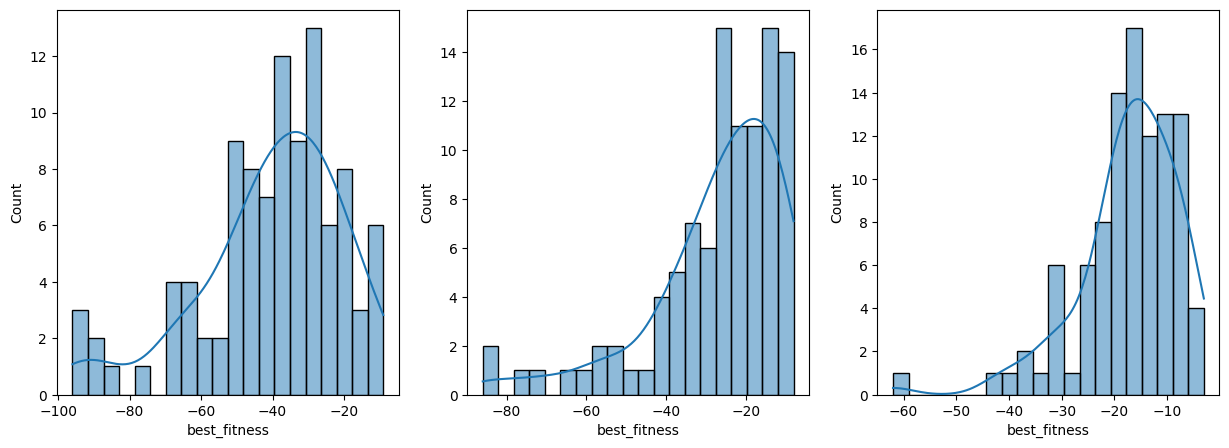

In [21]:
# do the same for best_fitness
fix, axs = plt.subplots(1, 3, figsize=(15, 5))
sns.histplot(data=stats_8['best_fitness'], ax=axs[0], kde=True, bins=20)
sns.histplot(data=stats_16['best_fitness'], ax=axs[1], kde=True, bins=20)
sns.histplot(data=stats_32['best_fitness'], ax=axs[2], kde=True, bins=20)

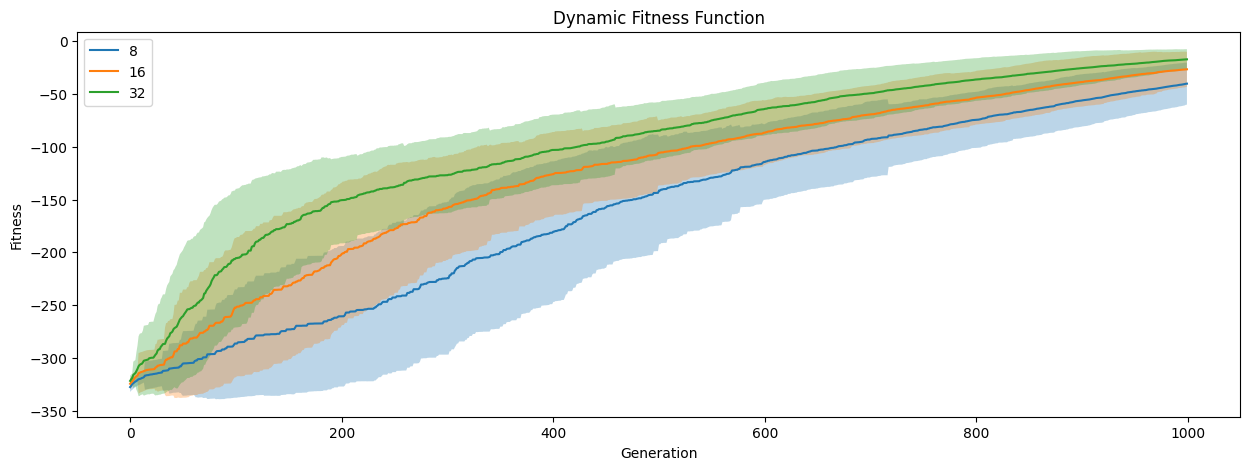

In [22]:
# from fitnesses array make a lineplot which is the mean of the 100 experiments and the std is the area around the mean
# compute mean and std
mean_8 = np.mean(fitnesses_8, axis=0)
mean_16 = np.mean(fitnesses_16, axis=0)
mean_32 = np.mean(fitnesses_32, axis=0)

std_8 = np.std(fitnesses_8, axis=0)
std_16 = np.std(fitnesses_16, axis=0)
std_32 = np.std(fitnesses_32, axis=0)

plt.figure(figsize=(15, 5))
plt.plot(mean_8, label='8')
plt.fill_between(range(len(mean_8)), mean_8-std_8, mean_8+std_8, alpha=0.3)
plt.plot(mean_16, label='16')
plt.fill_between(range(len(mean_16)), mean_16-std_16, mean_16+std_16, alpha=0.3)
plt.plot(mean_32, label='32')
plt.fill_between(range(len(mean_32)), mean_32-std_32, mean_32+std_32, alpha=0.3)
plt.xlabel('Generation')
plt.ylabel('Fitness')
plt.title('Dynamic Fitness Function')
plt.legend()
plt.show()

# Bibliography
# TODO: aima 